In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"





In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )

print("\n\n")




  numpy version:  1.26.4





## Set model and resolution parameters

In [3]:
ndim = 1

##-------------

train_mu = [ 0.0 ]



train_rho = [ [0.0] ]






train_sig = [ 1.0 ]


##-------------


true_mu = [ 0.2 ]






true_rho  = [ [0.0] ]



true_sig = [ 0.9 ]






#--- perfect
#resolution = [ 0.000001  ]

#--- very good
#resolution = [ 0.05  ]

#--- good
#resolution = [ 0.25  ]

#--- nominal
#resolution = [ 0.5  ]

#--- medium poor
resolution = [ 0.75  ]

#--- poor
#resolution = [ 1.0  ]







train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
                






ngen_train = 100000
ngen_true =   10000

#ngen_train = 1000000
#ngen_true =   100000

of_niter = 5


#use_poisson_fluctuations_around_ngen_true = True
use_poisson_fluctuations_around_ngen_true = False


do_bootstrap = False

n_boot_samples = 500



ds_input_dir = 'toy-study6b-1d-1a-10k'


output_dir = 'hist-pdf-toy-study-1d-3c'

#save_step2_model = True



hist_low = -10.
hist_high = 10.

hist_nbins = 1000


hist_binwidth = (hist_high - hist_low) / hist_nbins

window_dx = 0.10

window_nbins = int( window_dx / hist_binwidth )

print(' window_nbins : %d' % window_nbins)

hist_pars = {}
hist_pars['low']  = hist_low
hist_pars['high'] = hist_high
hist_pars['nbins'] = hist_nbins
hist_pars['binwidth'] = hist_binwidth
hist_pars['window_dx'] = window_dx
hist_pars['window_nbins'] = window_nbins






 Train covariance:
   0,  0 : diagonal    1.0000



 True covariance:
   0,  0 : diagonal    0.8100
 window_nbins : 5


In [4]:
hist_pars

{'low': -10.0,
 'high': 10.0,
 'nbins': 1000,
 'binwidth': 0.02,
 'window_dx': 0.1,
 'window_nbins': 5}

In [5]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()

In [6]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  1.000000
True covariance determinant:   0.810000





In [7]:
train_cov_inv = np.linalg.inv( train_cov )

In [8]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [9]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[1.]]

 Train covariance inverse
[[1.]]

 Train covariance inverse test
[[1.]]





In [10]:
true_cov_inv = np.linalg.inv( true_cov )

In [11]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [12]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[0.81]]

 True covariance inverse
[[1.2345679]]

 True covariance inverse test
[[1.]]





## Generate samples, save events and config

In [13]:

#--- Read the datasets instead of generating new ones.

train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)


this_ngen_true = ngen_true
if use_poisson_fluctuations_around_ngen_true : this_ngen_true = np.random.poisson( ngen_true )

true_pts = np.random.multivariate_normal(true_mu, true_cov, size=this_ngen_true)




train_det_pts = np.random.normal( train_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )



#with open('%s/train-and-true-samples.npy' % ds_input_dir, 'rb') as f :
#    train_pts = np.load(f)
#    train_det_pts = np.load(f)
#    true_pts = np.load(f)
#    true_det_pts = np.load(f)

print('\n\n train_pts:')
print( train_pts )
print('\n\n')
print(' train_pts shape:  %s' % str(train_pts.shape))

train_both = np.stack([train_pts, train_det_pts], axis=1)
    
#-- ok to regenerate these (just for plots)
true_pts10x = np.random.multivariate_normal(true_mu, true_cov, size=this_ngen_true*40)
true_det_pts10x = np.random.normal( true_pts10x, resolution )
true_pts10x_weights = np.ones( this_ngen_true*40 )
true_pts10x_weights = (1./40.) * true_pts10x_weights




 train_pts:
[[-0.90799938]
 [-0.66740389]
 [ 0.0337092 ]
 ...
 [-0.83741035]
 [ 1.74495637]
 [ 0.26144662]]



 train_pts shape:  (100000, 1)


In [14]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [15]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, train_cov )
    np.save( f, true_cov )

In [16]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )
config_file.write('use_poisson_fluctuations_around_total : %s\n' % str(use_poisson_fluctuations_around_ngen_true) )




config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('train_cov : %s\n' % str(train_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : hist-pdf-toy-study-1d-3c/config.txt

2024-08-08 08:52:13.750234

ngen_train 100000
ngen_true  10000
of_niter   5
ndim       1
use_poisson_fluctuations_around_total : False


train_mu : [0.0]
train_rho : [[0.0]]
train_sig : [1.0]
train_cov : [[1.]]


true_mu : [0.2]
true_rho : [[0.0]]
true_sig : [0.9]
true_cov : [[0.81]]


resolution : [0.75]





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

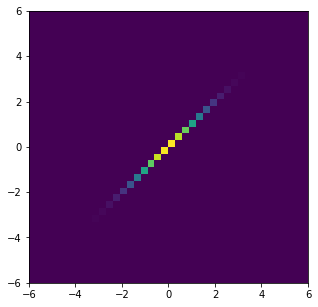

In [17]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
            
        thisax.hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

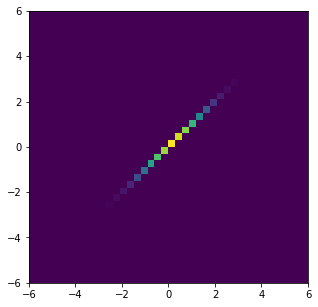

In [18]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
        thisax.hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

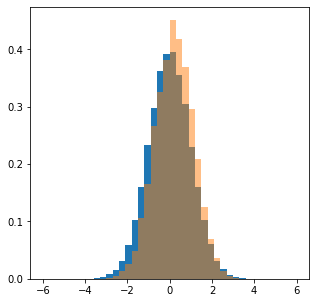

In [19]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        if ndim > 1 :
            thisax = ax[i]
        else :
            thisax = ax
        thisax.hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        thisax.hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

### Calculate true weights analytically and compare with unfolding output weights.

In [20]:
train_pts_minus_train_mu = train_pts - train_mu
print(train_pts_minus_train_mu)

[[-0.90799938]
 [-0.66740389]
 [ 0.0337092 ]
 ...
 [-0.83741035]
 [ 1.74495637]
 [ 0.26144662]]


In [21]:
train_pts_minus_true_mu = train_pts - true_mu
print(train_pts_minus_true_mu)

[[-1.10799938]
 [-0.86740389]
 [-0.1662908 ]
 ...
 [-1.03741035]
 [ 1.54495637]
 [ 0.06144662]]


In [22]:
true_cov_inv_times_v = np.tensordot( true_cov_inv, train_pts_minus_true_mu.T, axes=(1,0) )

In [23]:
v_times_true_cov_inv_times_v =  np.sum( train_pts_minus_true_mu.T * true_cov_inv_times_v, axis=0)

In [24]:
train_cov_inv_times_v = np.tensordot( train_cov_inv, train_pts_minus_train_mu.T, axes=(1,0) )

In [25]:
v_times_train_cov_inv_times_v =  np.sum( train_pts_minus_train_mu.T * train_cov_inv_times_v, axis=0)

In [26]:
exp_v_times_train_cov_inv_times_v = np.exp( -0.5 * v_times_train_cov_inv_times_v )
exp_v_times_true_cov_inv_times_v  = np.exp( -0.5 * v_times_true_cov_inv_times_v  )

In [27]:
true_cov_det = np.linalg.det( true_cov )
train_cov_det = np.linalg.det( train_cov )

In [28]:
norm2_true = np.power( 3.14159265, ndim) * true_cov_det
print("\n norm2_true : %f\n" % norm2_true )


 norm2_true : 2.544690



In [29]:
norm2_train = np.power( 3.14159265, ndim) * train_cov_det
print("\n norm2_train : %f\n" % norm2_train )


 norm2_train : 3.141593



In [30]:
pdf_train = exp_v_times_train_cov_inv_times_v / np.sqrt(norm2_train)
print(pdf_train)

[0.37358998 0.4515456  0.56386913 ... 0.39732806 0.1230947  0.54523297]


In [31]:
pdf_true = exp_v_times_true_cov_inv_times_v / np.sqrt(norm2_true)
print(pdf_true)

[0.29381033 0.39398502 0.61626763 ... 0.32260136 0.14364742 0.62541797]


In [32]:
pdf_ratio = pdf_true / pdf_train

In [33]:
sample_sf = (1.*len(true_pts))/(1.*len(train_pts))
print('\n sample_sf = %f' % sample_sf )


 sample_sf = 0.100000


In [34]:
calc_weight = pdf_ratio

In [35]:
calc_weight_scaled = sample_sf * pdf_ratio

In [36]:
with open( '%s/analytic-weights.npy' % output_dir, 'wb') as f :
    np.save(f, calc_weight_scaled)

## Define function for calculating model pars (mean and cov) from weighted events

In [37]:
def calc_mean_cov( weights, fi1, fi2, sample_points ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * sample_points[:,fi1] )
    wx2 = np.sum( weights * sample_points[:,fi2] )
    wx1x2 = np.sum( weights * sample_points[:,fi1] * sample_points[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * sample_points[:,fi1] * sample_points[:,fi1] )
        wx2x2 = np.sum( weights * sample_points[:,fi2] * sample_points[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [38]:
weights_true = np.ones( this_ngen_true )

In [39]:
true_calc_mean = np.zeros( ndim )
true_calc_cov = np.ones( shape=(ndim,ndim) )

In [40]:
for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        rd = calc_mean_cov( weights_true, fi1, fi2, true_pts )
        true_calc_mean[fi1] = rd['mean_x1']
        true_calc_cov[fi1,fi2] = rd['cov_x1x2']

In [41]:
for fi1 in range(ndim) :
    print('  mean f%d :  %7.3f' % (fi1, true_calc_mean[fi1]))
    for fi2 in range(fi1,ndim) :
        print('  cov f%df%d :  %7.4f' % (fi1,fi2, true_calc_cov[fi1,fi2]))
        if fi1 == fi2 :
            print('  sigma f%d :  %7.4f' % (fi1, np.sqrt(true_calc_cov[fi1,fi1])))
        

  mean f0 :    0.210
  cov f0f0 :   0.8129
  sigma f0 :   0.9016


In [42]:
print( true_pts.shape )
print( true_pts.shape[1])

(10000, 1)
1


In [43]:
def calc_model_pars( weights, sample_points, verbose=0 ) :
    
    return_dict = {}
    
    ndim = sample_points.shape[1]
    if verbose : print(' ndim = %d' % ndim )
    
    model_mean = np.zeros( ndim )
    model_cov = np.ones( shape=(ndim,ndim) )
    
    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            rd = calc_mean_cov( weights, fi1, fi2, sample_points )
            model_mean[fi1] = rd['mean_x1']
            model_cov[fi1,fi2] = rd['cov_x1x2']    
            if verbose and fi2==fi1 : print('  mean f%d :  %7.3f' % (fi1, model_mean[fi1]))
            if verbose : print('  cov f%df%d :  %7.4f' % (fi1,fi2, model_cov[fi1,fi2]))
            if verbose and fi2==fi1 : print('  sigma f%d :  %7.4f' % (fi1, np.sqrt(model_cov[fi1,fi1])))
   
    for fi2 in range(ndim) :
        for fi1 in range(fi2+1,ndim) :
            model_cov[fi1,fi2] = model_cov[fi2,fi1]
    
    return_dict['mean'] = model_mean
    return_dict['cov']  = model_cov
    
    return return_dict


In [44]:
test_calc_true_model = calc_model_pars( weights_true, true_pts, 1)

 ndim = 1
  mean f0 :    0.210
  cov f0f0 :   0.8129
  sigma f0 :   0.9016


In [45]:
test_calc_true_model

{'mean': array([0.21040576]), 'cov': array([[0.81294538]])}

## Define function to calculate the reweighting factor (pdf2/pdf1).

In [46]:
def calc_pdf_ratio( model1_mu, model2_mu, model1_cov, model2_cov, sample_points ) :
    
    ndim = len(model1_mu)
    
    pts_minus_mu1 = sample_points - model1_mu
    pts_minus_mu2 = sample_points - model2_mu
    
    cov1_inv = np.linalg.inv( model1_cov )
    cov2_inv = np.linalg.inv( model2_cov )
    
    cov1_det = np.linalg.det( model1_cov )
    cov2_det = np.linalg.det( model2_cov )
    
    cov1_inv_times_v1 = np.tensordot( cov1_inv, pts_minus_mu1.T, axes=(1,0) )
    cov2_inv_times_v2 = np.tensordot( cov2_inv, pts_minus_mu2.T, axes=(1,0) )
    
    v1_times_cov1_inv_times_v1 =  np.sum( pts_minus_mu1.T * cov1_inv_times_v1, axis=0)
    v2_times_cov2_inv_times_v2 =  np.sum( pts_minus_mu2.T * cov2_inv_times_v2, axis=0)
    
    exp_v1_times_cov1_inv_times_v1 = np.exp( -0.5 * v1_times_cov1_inv_times_v1 )
    exp_v2_times_cov2_inv_times_v2 = np.exp( -0.5 * v2_times_cov2_inv_times_v2 )
    
    norm2_model1 = np.power( 3.14159265, ndim) * cov1_det
    norm2_model2 = np.power( 3.14159265, ndim) * cov2_det
    
    pdf1 = exp_v1_times_cov1_inv_times_v1 / np.sqrt(norm2_model1)
    pdf2 = exp_v2_times_cov2_inv_times_v2 / np.sqrt(norm2_model2)
    
    pdf_ratio = pdf1 / pdf2
    
    return pdf_ratio
    
    

In [47]:
test_calc_pdf_ratio = calc_pdf_ratio( true_mu, train_mu, true_cov, train_cov, train_pts )

In [48]:
test_calc_pdf_ratio

array([0.7864513 , 0.87252543, 1.0929267 , ..., 0.81192694, 1.16696677,
       1.14706558])

In [49]:
pdf_ratio

array([0.7864513 , 0.87252543, 1.0929267 , ..., 0.81192694, 1.16696677,
       1.14706558])

## Function that estimates the pdf from a histogram (multi-bin sum)

In [50]:

#-- computes pdf2/pdf1 at location of points1
#
#    for OmniFold step 1, points2 is the data, points1 is the MC
#

def pdf_ratio_from_hist( points1, points2, weights1, weights2, hist_pars, verbose=0 ) :
    
    ndim = points1.shape[1]
    
    if ndim > 1 :
        print('\n\n *** Only 1D supported for now.\n\n')
        sys.exit()
        
    hist_low = hist_pars['low']
    hist_high = hist_pars['high']
    hist_nbins = hist_pars['nbins']
    hist_binwidth = hist_pars['binwidth']
    
    
    nph1 = np.histogram( points1[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights1 )
    nph2 = np.histogram( points2[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights2 )
    
    hist_pdf1 = np.zeros(hist_nbins)
    hist_pdf2 = np.zeros(hist_nbins)

    for bi in range( hist_nbins ) :
        bilow = bi - window_nbins
        bihigh = bi + window_nbins
        if bilow < 0 : bilow = 0
        if bihigh >= hist_nbins : bihigh = hist_nbins-1

        hist_pdf1[bi] = np.sum( nph1[0][bilow: bihigh] )
        hist_pdf2[bi] = np.sum( nph2[0][bilow: bihigh] )
    
    hist_pdf1_norm = hist_pdf1 / np.sum(hist_pdf1)
    hist_pdf2_norm = hist_pdf2 / np.sum(hist_pdf2)
    
    hist_bin_indices1 = np.array(   ( (points1[:,0] - hist_low) / hist_binwidth ),   dtype=int )
    
    points1_pdf1_val = hist_pdf1_norm[ hist_bin_indices1 ]
    points1_pdf2_val = hist_pdf2_norm[ hist_bin_indices1 ]
    
    points1_pdf1_val = np.clip( points1_pdf1_val, 1.e-10, 1.e10)
    points1_pdf2_val = np.clip( points1_pdf2_val, 1.e-10, 1.e10)
    
    pdf_ratio = points1_pdf2_val / points1_pdf1_val
    
    return pdf_ratio
    

In [51]:
print('pdf_ratio shape : %s' % str(pdf_ratio.shape))

pdf_ratio shape : (100000,)


In [52]:
weights_true = np.ones( this_ngen_true )
weights_train = np.ones( ngen_train )

print(' train_pts shape: %s' % str(train_pts.shape))
print('  true_pts shape: %s' % str(true_pts.shape))
print(' weights_train shape: %s' % str(weights_train.shape))
print('  weights_true shape: %s' % str(weights_true.shape))

test_hist_pdf_ratio = pdf_ratio_from_hist( train_pts, true_pts, weights_train, weights_true, hist_pars )

 train_pts shape: (100000, 1)
  true_pts shape: (10000, 1)
 weights_train shape: (100000,)
  weights_true shape: (10000,)


In [53]:
pdf_ratio

array([0.7864513 , 0.87252543, 1.0929267 , ..., 0.81192694, 1.16696677,
       1.14706558])

In [54]:
calc_weight

array([0.7864513 , 0.87252543, 1.0929267 , ..., 0.81192694, 1.16696677,
       1.14706558])

In [55]:
test_hist_pdf_ratio

array([0.81035134, 0.84453582, 1.08857251, ..., 0.94519317, 1.23745819,
       1.15523002])

In [56]:
test_hist_pdf_ratio.shape

(100000,)

In [57]:
for pi in range(40) :
    print( ' %3d   x %7.3f   true  %7.4f  from hist %7.4f' % (pi, train_pts[pi,0], calc_weight[pi], test_hist_pdf_ratio[pi]))

   0   x  -0.908   true   0.7865  from hist  0.8104
   1   x  -0.667   true   0.8725  from hist  0.8445
   2   x   0.034   true   1.0929  from hist  1.0886
   3   x  -1.584   true   0.5464  from hist  0.5000
   4   x  -0.864   true   0.8023  from hist  0.9037
   5   x   1.005   true   1.2341  from hist  1.3147
   6   x   0.674   true   1.2139  from hist  1.1715
   7   x   0.456   true   1.1840  from hist  1.1910
   8   x   1.678   true   1.1791  from hist  1.1962
   9   x   0.411   true   1.1762  from hist  1.2063
  10   x  -0.149   true   1.0421  from hist  0.9697
  11   x  -0.714   true   0.8561  from hist  0.8788
  12   x   1.209   true   1.2309  from hist  1.2371
  13   x   1.460   true   1.2106  from hist  1.3427
  14   x  -2.511   true   0.2784  from hist  0.2402
  15   x  -1.356   true   0.6250  from hist  0.6516
  16   x  -1.356   true   0.6250  from hist  0.6516
  17   x  -0.506   true   0.9284  from hist  0.8873
  18   x   0.047   true   1.0963  from hist  1.0979
  19   x  -1

## Define OmniFold implementation with fit pdf

In [58]:
def hist_pdf_omnifold1a( theta0, theta_unknown_S, iterations, verbose=0 ) :
    
    weights = np.empty(shape=(iterations, 2, len(theta0)))
    # shape = (iteration, step, event)
    push_weights_for_output = np.empty(shape=(iterations, len(theta0)))

    theta0_G = theta0[:,0]
    theta0_S = theta0[:,1]

    ngen_train = len(theta0)
    of_ngen_true  = len(theta_unknown_S)
    ndim = theta0_G.shape[1]

    labels0 = np.zeros(len(theta0))
    labels_unknown = np.ones(len(theta_unknown_S))
    labels_unknown_step2 = np.ones(len(theta0_G))


    neval_train = ngen_train
    neval_true  = of_ngen_true


    if verbose :
        print("\n\n")
        print("  ======== simple_pdf2b\n\n")
        print("  shape of theta0_S : %s" % str(np.shape(theta0_S)) )
        print("  shape of theta0_G : %s" % str(np.shape(theta0_G)) )
        print("  shape of theta_unknown_S : %s" % str(np.shape(theta_unknown_S)) )
        print("\n  iterations = %d\n" % iterations )
        print("  ndim : %d" % ndim )
        print("  neval_train : %d" % neval_train )
        print("  neval_true  : %d" % neval_true )
        print("\n\n")

    # initial iterative weights are ones
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))


    sample_norm_sf = ( (1.*neval_train)/(1.*neval_true) ) *  ( (1.*of_ngen_true)/(1.*ngen_train) )
    
    
    if verbose :
        print('\n\n Calculating model pars for data or true (theta_unknown_S)')
        
    

    
    
    
    
    
    
    return_dict = {}
    
    for i in range(iterations):
    
        if (verbose>0):
            print("\nITERATION: {}\n".format(i + 1))
            
        if (verbose>0):
            print("   -- ITERATION %d  STEP 1\n" % (i+1) )
            
        print(" weights_push at the beginning")
        print( weights_push )

        


        pdf_ratio_step1 = pdf_ratio_from_hist( theta0_S, 
                                              theta_unknown_S, 
                                              weights_push, 
                                              np.ones( of_ngen_true ),
                                              hist_pars
                                             )
        if verbose>0 :
            print(' pdf_ratio_step1:  shape %s ' % str(pdf_ratio_step1.shape))
            print(pdf_ratio_step1)
        
        
        step1_output_weights = sample_norm_sf * pdf_ratio_step1

        weights_pull = weights_push * step1_output_weights
        
        if verbose>0 :
            print("  iter %d, step1_output_weights:  shape %s" % (i+1, str(step1_output_weights.shape)))
            print(step1_output_weights)


        weights[i, :1, :] = step1_output_weights


            
            

        if (verbose>0):
            print("\n   -- ITERATION %d  STEP 2\n" % (i+1) )
            
        #if verbose : print(' calculation of model pars with push weights')
        #model_pars_theta0_G_push_weight = calc_model_pars( weights_push, theta0_G, verbose )

        #if verbose : print(' calculation of model pars with pull weights')
        #model_pars_theta0_G_pull_weight = calc_model_pars( weights_pull, theta0_G, verbose )
        
        #pdf_ratio_step2 = calc_pdf_ratio( model_pars_theta0_G_pull_weight['mean'],
        #                           model_pars_theta0_G_push_weight['mean'],
        #                           model_pars_theta0_G_pull_weight['cov'],
        #                           model_pars_theta0_G_push_weight['cov'],
        #                           theta0_G )        

        
        pdf_ratio_step2 = pdf_ratio_from_hist( theta0_G, 
                                              theta0_G, 
                                              weights_push, 
                                              weights_pull,
                                              hist_pars
                                             )
        
        
        step2_output_weights = pdf_ratio_step2
        
        weights_push = weights_push * step2_output_weights
        
        push_weights_for_output[i] = weights_push
        
        weights[i, 1:2, :] = step2_output_weights
        
        if verbose>0 :
           print("  iter %d, step2_output_weights:" % (i+1))
           print(step2_output_weights)
        
    return_dict["weights"] = weights

    return_dict["push_weights"] = push_weights_for_output

    return_dict["final_push_weights"] = weights_push

    return return_dict
            
            

In [59]:
rd = hist_pdf_omnifold1a( train_both, true_det_pts, of_niter, 1 )




  ======== simple_pdf2b


  shape of theta0_S : (100000, 1)
  shape of theta0_G : (100000, 1)
  shape of theta_unknown_S : (10000, 1)

  iterations = 5

  ndim : 1
  neval_train : 100000
  neval_true  : 10000





 Calculating model pars for data or true (theta_unknown_S)

ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 pdf_ratio_step1:  shape (100000,) 
[0.67078972 0.61525841 0.69435637 ... 1.01439791 1.14814815 0.89821662]
  iter 1, step1_output_weights:  shape (100000,)
[0.67078972 0.61525841 0.69435637 ... 1.01439791 1.14814815 0.89821662]

   -- ITERATION 1  STEP 2

  iter 1, step2_output_weights:
[0.86261209 0.91121149 1.03821343 ... 0.88150334 1.16696447 1.07695877]

ITERATION: 2

   -- ITERATION 2  STEP 1

 weights_push at the beginning
[0.86261209 0.91121149 1.03821343 ... 0.88150334 1.16696447 1.07695877]
 pdf_ratio_step1:  shape (100000,) 
[0.84029824 0.82920954 0.81350372 ... 1.03033314 1.0045686  0.9818806 ]
  iter 2, ste

In [60]:
of_weights = rd["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = rd["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = rd["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)


<function matplotlib.pyplot.show(close=None, block=None)>

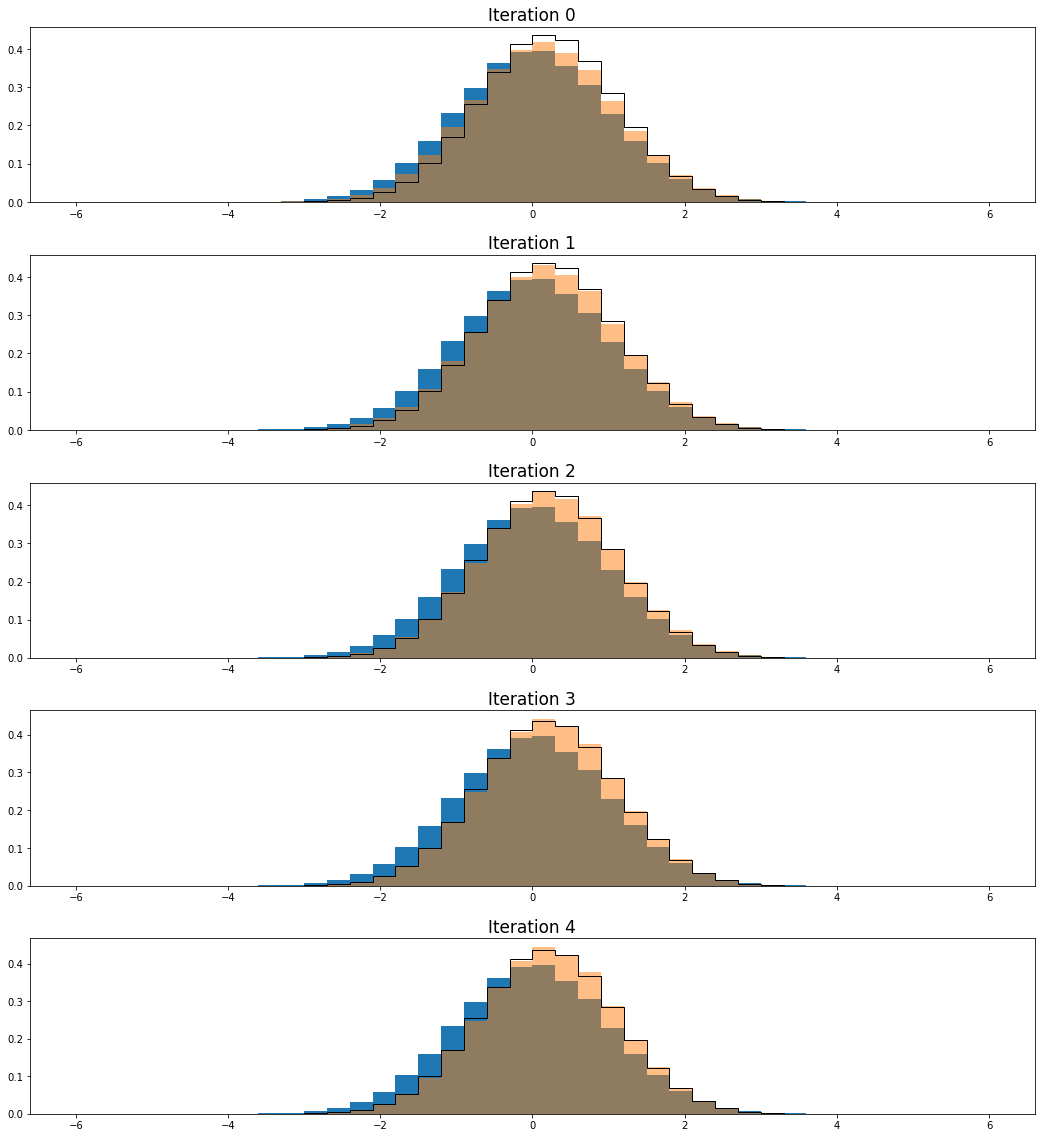

In [61]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
                
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
 
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
        
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [62]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

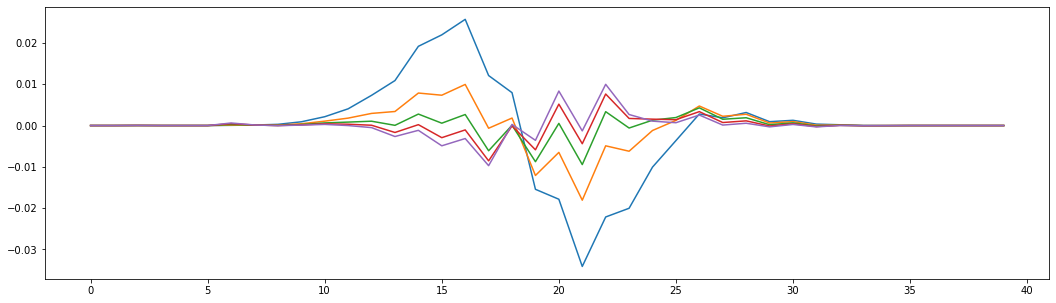

In [63]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

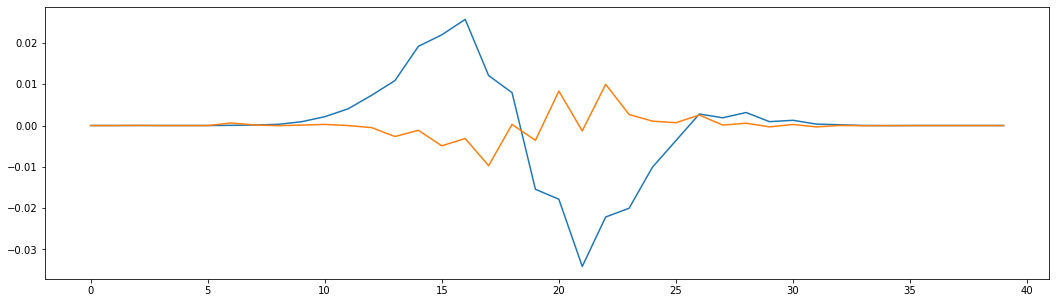

In [64]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])
    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

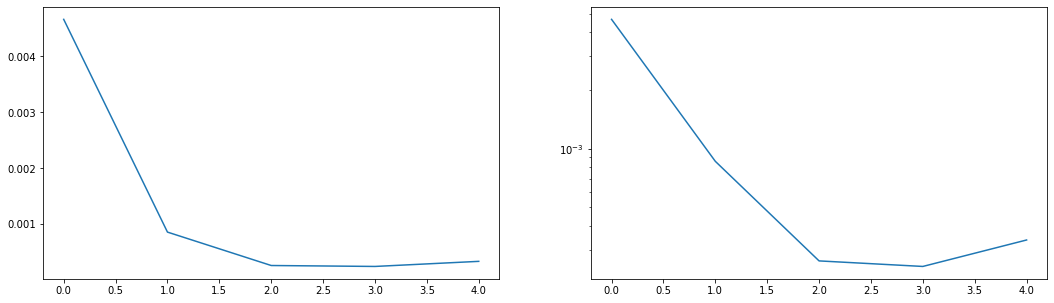

In [65]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

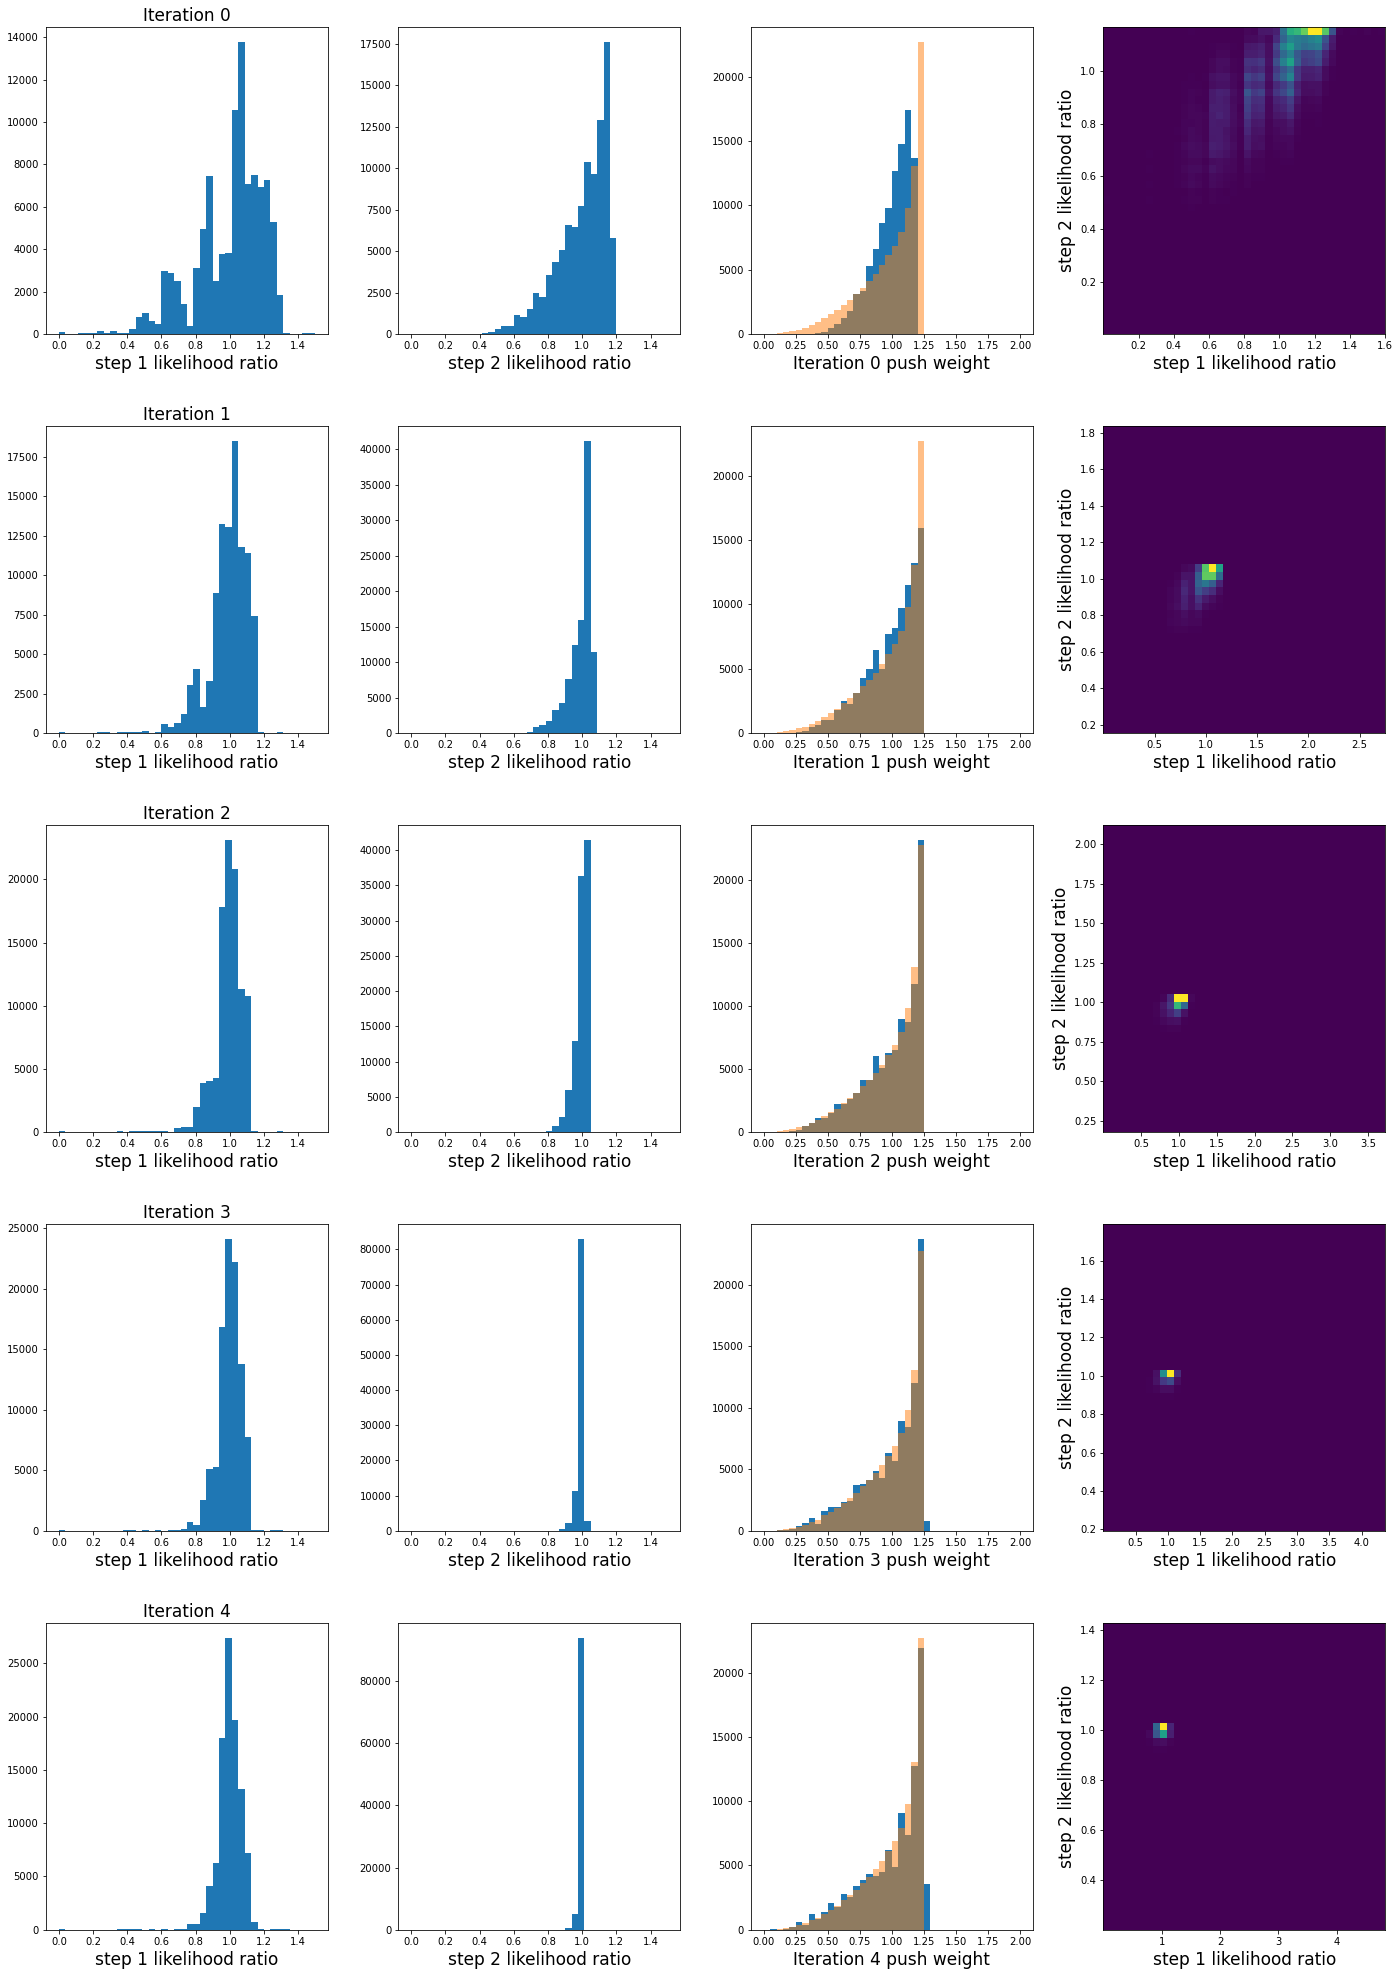

In [66]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.0] )
    ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'Iteration %d push weight' % ofi, fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

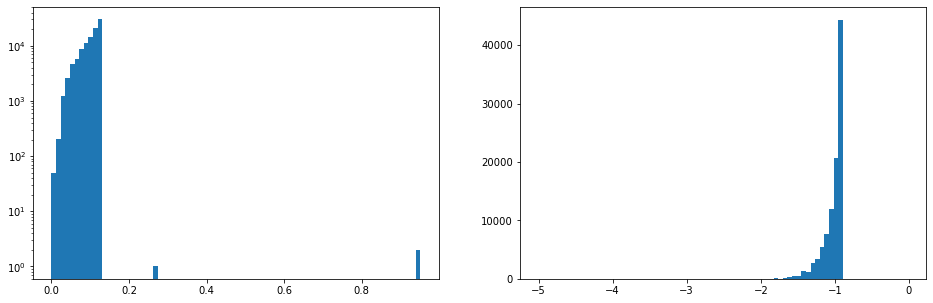

In [67]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

final_push_weights_scaled = np.clip( final_push_weights_scaled, 1e-11, 1e11)

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

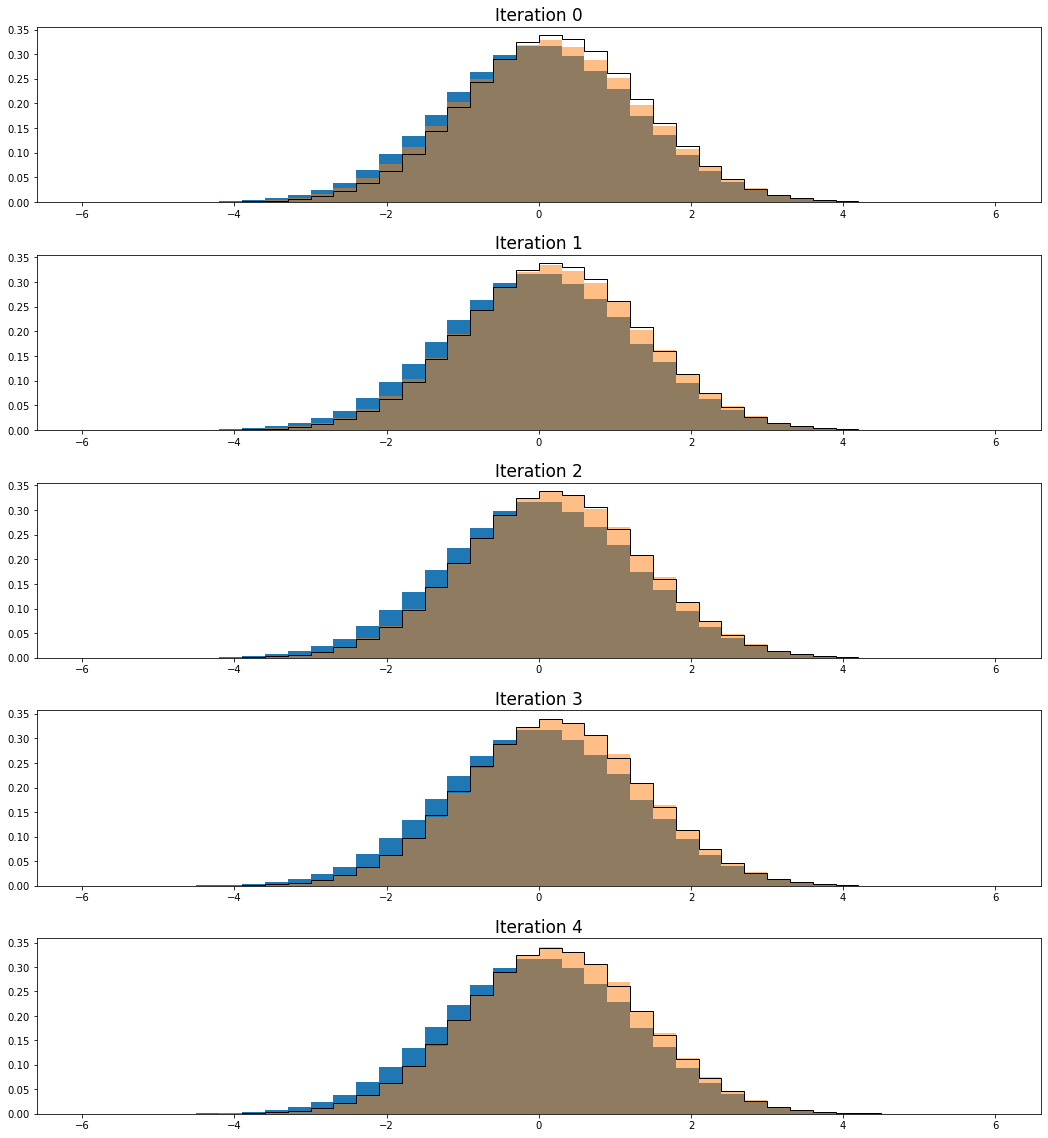

In [68]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
    
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [69]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

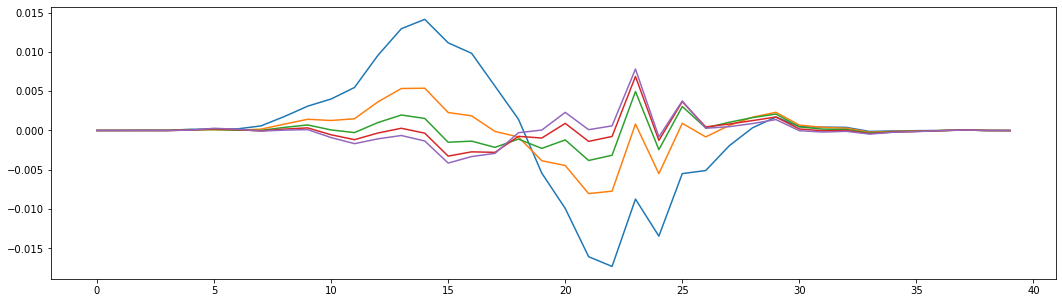

In [70]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

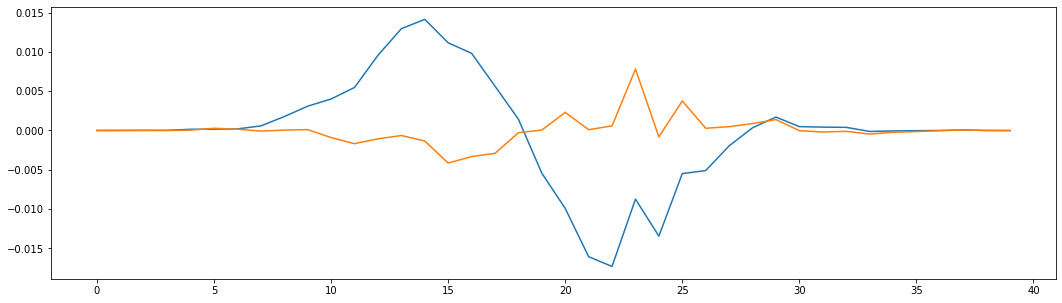

In [71]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

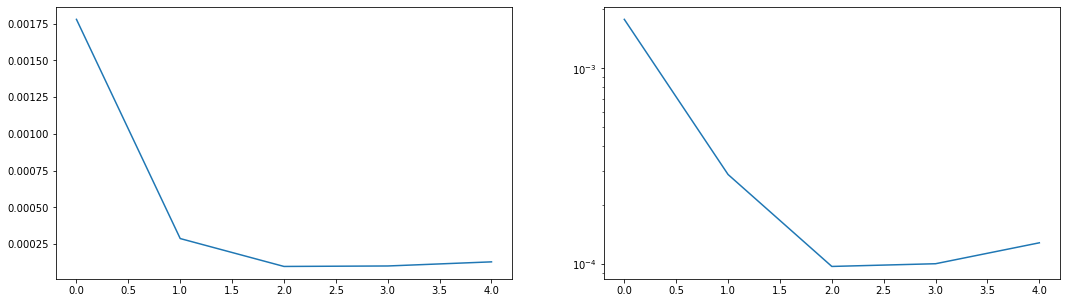

In [72]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [73]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  0.999  rms 0.202      step 2 mean  0.999  rms 0.147
  iter  1 : step 1 mean  0.990  rms 0.119      step 2 mean  0.989  rms 0.071
  iter  2 : step 1 mean  0.993  rms 0.093      step 2 mean  0.993  rms 0.038
  iter  3 : step 1 mean  0.996  rms 0.085      step 2 mean  0.996  rms 0.023
  iter  4 : step 1 mean  0.997  rms 0.083      step 2 mean  0.997  rms 0.016


<function matplotlib.pyplot.show(close=None, block=None)>

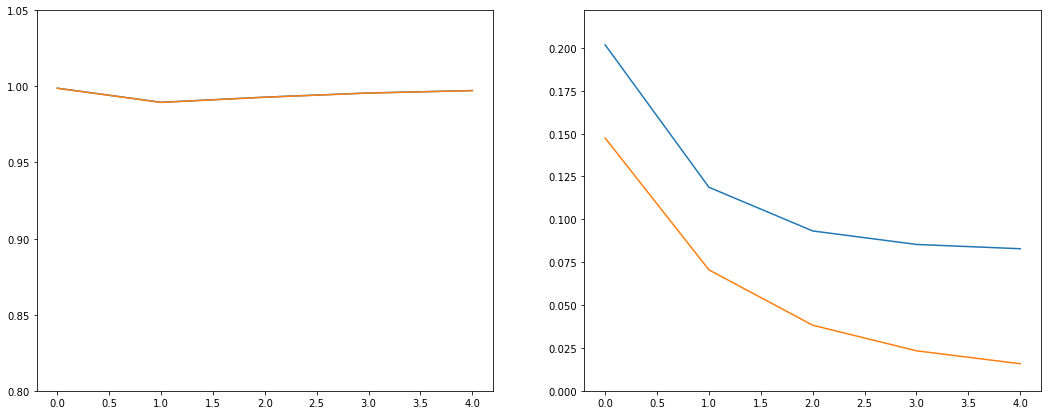

In [74]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

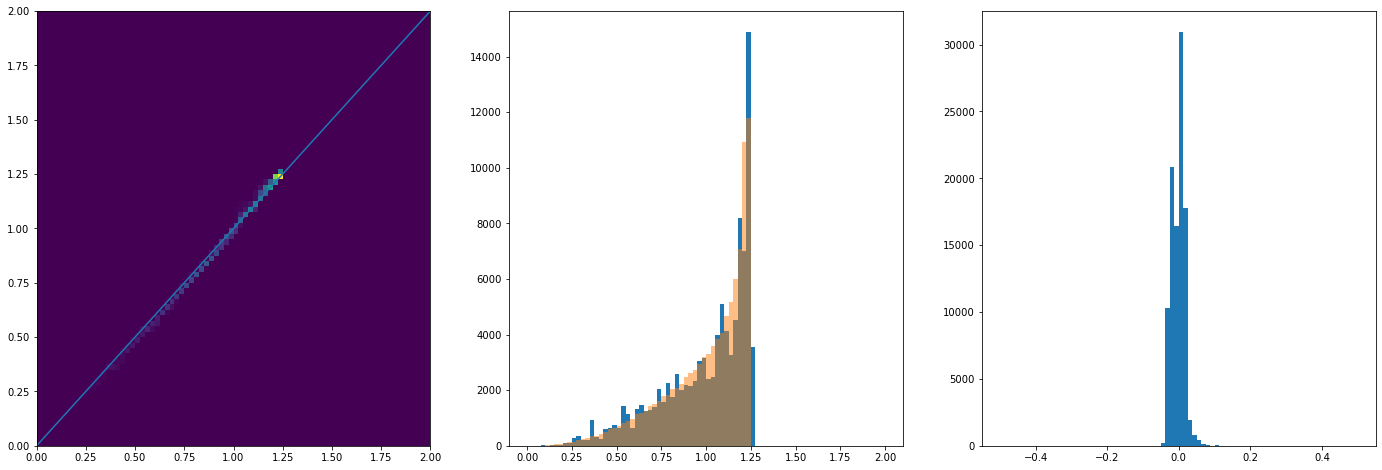

In [75]:
fig,ax = plt.subplots( 1, 3, figsize=(3*8,1*8))
max_weight = 2.0

ax[0].hist2d( calc_weight, final_push_weights, bins=[80,80], range=([0,max_weight],[0,max_weight]))
ax[0].plot([0,max_weight],[0,max_weight])

ax[1].hist( final_push_weights, bins=80, range=[0,max_weight] )
ax[1].hist( calc_weight, bins=80, range=[0,max_weight], alpha=0.5 )

ax[2].hist( final_push_weights-calc_weight, bins=80, range=[-0.5,0.5] )

plt.show

In [76]:

delta_weight_rms = np.sqrt( np.var( np.clip(final_push_weights-calc_weight,-0.5,0.5 ) ) )
print('\n\n Delta weight RMS:  %.5f\n\n' % delta_weight_rms )



 Delta weight RMS:  0.01966




In [77]:

verbose = False



import gc

In [78]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    if do_bootstrap :
        #print("\n Creating bootstrap sample %3d" % bi )
        #boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        fname = "%s/bootstrap-points-%03d.npy" % (ds_input_dir, bi)
        print('\n Reading bootstrap sample from file: %s' % fname )
        with open( fname, 'rb' ) as f :
            boot_true_det_pts = np.load(f)
        
    else :
        this_ngen_true = ngen_true
        if use_poisson_fluctuations_around_ngen_true : this_ngen_true = np.random.poisson( ngen_true )
        print("\n Creating toy sample %3d,  this_ngen_true = %d" % (bi, this_ngen_true) )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=this_ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, resolution )
        

        
#    boot_of_return_dict = of.omnifold6b( 
#        train_both, boot_true_det_pts, of_niter, model, verbose, 
#        batch_size_setval, learning_rate_setval, epochs_setval )

#    rd = simple_pdf.simple_pdf2b( train_both, boot_true_det_pts, 
#                             train_train_det_within_sphere, train_train_gen_within_sphere,
#                             of_niter, radius, norm_radius2, False, False )

#    rd = fit_pdf_omnifold1a( train_both, boot_true_det_pts, of_niter, 0 )
    
    rd = hist_pdf_omnifold1a( train_both, boot_true_det_pts, of_niter, 0 )
    
    
    
    mc_weight_sf = (1.*len(boot_true_det_pts))/(1.*len(train_both))



    boot_final_push_weights = rd["final_push_weights"]
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

     
    with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_final_push_weights_scaled )
        
    del boot_final_push_weights_scaled
    del rd
    gc.collect()
    
    


 Creating toy sample   0,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88085043 0.92460948 1.03802205 ... 0.89780028 1.13008919 1.0725006 ]
 weights_push at the beginning
[0.83132371 0.89382867 1.05820809 ... 0.85563298 1.15584617 1.10789804]
 weights_push at the beginning
[0.80966196 0.88169652 1.07154097 ... 0.83787431 1.1497332  1.12833354]
 weights_push at the beginning
[0.7996723  0.87701393 1.08051585 ... 0.8302173  1.13675034 1.14097398]


 bootstrap 0 final push weights scaled:
[0.07949182 0.08753234 0.10864322 ... 0.08269609 0.11245425 0.11490565]

 Creating toy sample   1,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.86693191 0.91143064 1.02979899 ... 0.88435151 1.18632589 1.06696189]
 weights_push at the beginning
[0.81369252 0.87636489 1.0449922  ... 0.83851133 1.24184387 1.09702572]
 weights_push at the beginning
[0.79139576 0.86321776 1.


 Creating toy sample  13,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.86451992 0.91214984 1.03596838 ... 0.8828939  1.16720916 1.07311681]
 weights_push at the beginning
[0.80764076 0.87584769 1.05608289 ... 0.83407909 1.2082928  1.10927948]
 weights_push at the beginning
[0.78153386 0.86084745 1.07102683 ... 0.81251347 1.20770843 1.13163235]
 weights_push at the beginning
[0.76800109 0.85420718 1.08239176 ... 0.80196982 1.19619835 1.14687015]


 bootstrap 13 final push weights scaled:
[0.07599735 0.08508511 0.10909908 ... 0.07961138 0.11837242 0.11578758]

 Creating toy sample  14,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.86886685 0.91390267 1.03390546 ... 0.88624917 1.16560189 1.07112178]
 weights_push at the beginning
[0.81504631 0.87846814 1.05113662 ... 0.83963094 1.2102166  1.10398386]
 weights_push at the beginning
[0.79173469 0.86414135 1


 Creating toy sample  26,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.85844878 0.90463677 1.03179454 ... 0.8763631  1.19092105 1.07150881]
 weights_push at the beginning
[0.80134653 0.86556503 1.04706248 ... 0.82647238 1.2468456  1.10253747]
 weights_push at the beginning
[0.77755427 0.85023227 1.05789543 ... 0.80635378 1.2557925  1.11912648]
 weights_push at the beginning
[0.76743036 0.84443341 1.06580696 ... 0.79839517 1.25096624 1.12856886]


 bootstrap 26 final push weights scaled:
[0.07632547 0.08424847 0.10714601 ... 0.07956216 0.12436442 0.11339093]

 Creating toy sample  27,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.86679906 0.91409825 1.03384742 ... 0.88481799 1.17748402 1.07255372]
 weights_push at the beginning
[0.81241691 0.8801304  1.05096459 ... 0.83830654 1.2293508  1.10624163]
 weights_push at the beginning
[0.78911381 0.86785798 1


 Creating toy sample  39,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87719452 0.9170858  1.03194355 ... 0.89132785 1.14251866 1.06958585]
 weights_push at the beginning
[0.8269972  0.88197451 1.04786854 ... 0.845978   1.17448051 1.10307807]
 weights_push at the beginning
[0.80555522 0.8667699  1.05827579 ... 0.82611633 1.17070001 1.12256026]
 weights_push at the beginning
[0.79602963 0.85958682 1.06523593 ... 0.81673427 1.15793071 1.13493233]


 bootstrap 39 final push weights scaled:
[0.07917831 0.08557132 0.10697707 ... 0.08119021 0.11447313 0.11432116]

 Creating toy sample  40,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87344185 0.91343098 1.02518042 ... 0.88837308 1.1649801  1.06312783]
 weights_push at the beginning
[0.82210787 0.87787217 1.03696987 ... 0.84291391 1.21084188 1.09188766]
 weights_push at the beginning
[0.80002996 0.86325891 1


 Creating toy sample  52,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88230148 0.92736691 1.03796087 ... 0.89967002 1.14560417 1.07048865]
 weights_push at the beginning
[0.83455866 0.89978168 1.0585859  ... 0.85978375 1.18128803 1.10399349]
 weights_push at the beginning
[0.8146186  0.89084091 1.07270914 ... 0.84426457 1.18224695 1.12294757]
 weights_push at the beginning
[0.80613276 0.88911607 1.08255307 ... 0.83861447 1.17490228 1.13436398]


 bootstrap 52 final push weights scaled:
[0.08026282 0.08900791 0.1089292  ... 0.0837083  0.11675188 0.11413761]

 Creating toy sample  53,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88139681 0.92400437 1.03180562 ... 0.89701482 1.16297394 1.06507083]
 weights_push at the beginning
[0.83564144 0.89599615 1.04839051 ... 0.85745118 1.20675935 1.09430596]
 weights_push at the beginning
[0.81836031 0.88754512 1


 Creating toy sample  65,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88560182 0.92757737 1.03449599 ... 0.90202399 1.13704755 1.06471178]
 weights_push at the beginning
[0.83808065 0.89859855 1.05402234 ... 0.86205556 1.16913745 1.09596891]
 weights_push at the beginning
[0.81683169 0.88731309 1.06786628 ... 0.8451897  1.16772741 1.11403955]
 weights_push at the beginning
[0.80628959 0.88284473 1.07795203 ... 0.83760921 1.1580899  1.12531727]


 bootstrap 65 final push weights scaled:
[0.08003735 0.08809602 0.10853225 ... 0.08339102 0.11482063 0.11326472]

 Creating toy sample  66,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87919082 0.91964262 1.03054868 ... 0.89448552 1.14762771 1.06506648]
 weights_push at the beginning
[0.82877623 0.88599781 1.04668329 ... 0.85038482 1.18542516 1.09621329]
 weights_push at the beginning
[0.80587464 0.87148141 1


 Creating toy sample  78,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87301945 0.91748048 1.03107479 ... 0.88945378 1.16803214 1.06738021]
 weights_push at the beginning
[0.82138403 0.88483102 1.04618182 ... 0.84463163 1.21732096 1.09747422]
 weights_push at the beginning
[0.79941953 0.87292959 1.05619074 ... 0.82617582 1.22659845 1.11365495]
 weights_push at the beginning
[0.78951343 0.8691956  1.06292706 ... 0.81834255 1.22483357 1.12290102]


 bootstrap 78 final push weights scaled:
[0.07847315 0.08686258 0.1067288  ... 0.08149064 0.12216061 0.11282142]

 Creating toy sample  79,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.874611   0.91525562 1.03007701 ... 0.88976827 1.15681171 1.06686652]
 weights_push at the beginning
[0.82304889 0.87956313 1.04524205 ... 0.84397757 1.1993797  1.09814702]
 weights_push at the beginning
[0.80068096 0.86429943 1


 Creating toy sample  91,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.85475547 0.90435246 1.02879906 ... 0.87327103 1.19185838 1.06780784]
 weights_push at the beginning
[0.79408865 0.86565865 1.04350232 ... 0.82055962 1.24569515 1.09767481]
 weights_push at the beginning
[0.76631455 0.85066179 1.05477864 ... 0.79729659 1.25134456 1.11432814]
 weights_push at the beginning
[0.75185541 0.84510893 1.06359772 ... 0.78591073 1.24297465 1.12444459]


 bootstrap 91 final push weights scaled:
[0.0743153  0.08433853 0.10703771 ... 0.07795687 0.12321485 0.11307467]

 Creating toy sample  92,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87630024 0.92018416 1.03305318 ... 0.89367843 1.15163027 1.06903292]
 weights_push at the beginning
[0.82630117 0.8888772  1.05021075 ... 0.85152513 1.18634026 1.10157764]
 weights_push at the beginning
[0.80530759 0.8775907  1


 Creating toy sample 104,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87624464 0.9224794  1.04187108 ... 0.8941711  1.1483759  1.07576719]
 weights_push at the beginning
[0.82511062 0.89132641 1.0645482  ... 0.85096838 1.18491507 1.11230623]
 weights_push at the beginning
[0.80304585 0.8796429  1.08006887 ... 0.83326081 1.18671796 1.13334438]
 weights_push at the beginning
[0.79306089 0.87560882 1.09095847 ... 0.82599293 1.18065806 1.14630343]


 bootstrap 104 final push weights scaled:
[0.07883702 0.08744839 0.10985196 ... 0.08231312 0.11750542 0.11545155]

 Creating toy sample 105,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.86553659 0.91158215 1.02954486 ... 0.88260069 1.18856287 1.06590593]
 weights_push at the beginning
[0.81139432 0.87721395 1.0452625  ... 0.83564992 1.24353765 1.09548472]
 weights_push at the beginning
[0.78839537 0.86501248 


 Creating toy sample 117,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87437899 0.92050369 1.0374052  ... 0.89222769 1.14428132 1.07229404]
 weights_push at the beginning
[0.82086447 0.8874303  1.05756219 ... 0.84667185 1.17855354 1.10762853]
 weights_push at the beginning
[0.79603958 0.87375534 1.07136644 ... 0.8263077  1.17794572 1.12836061]
 weights_push at the beginning
[0.78316933 0.86783728 1.08108688 ... 0.81633229 1.16899698 1.14153266]


 bootstrap 117 final push weights scaled:
[0.07756447 0.08650491 0.1087885  ... 0.08108759 0.11600448 0.11502775]

 Creating toy sample 118,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87661468 0.92357156 1.03467926 ... 0.89426645 1.1590235  1.06882998]
 weights_push at the beginning
[0.82680059 0.89517547 1.05311054 ... 0.8522837  1.19983374 1.10054847]
 weights_push at the beginning
[0.80601675 0.88665795 


 Creating toy sample 130,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87636331 0.92005372 1.02996006 ... 0.89323829 1.167736   1.0659996 ]
 weights_push at the beginning
[0.8279951  0.8902394  1.04455958 ... 0.85218847 1.21351471 1.09505162]
 weights_push at the beginning
[0.80911071 0.88106076 1.05428941 ... 0.83732203 1.21844319 1.1104751 ]
 weights_push at the beginning
[0.80212869 0.87985276 1.06074108 ... 0.83289629 1.21223947 1.11908652]


 bootstrap 130 final push weights scaled:
[0.08001679 0.08816214 0.10647234 ... 0.08327266 0.12046394 0.11238012]

 Creating toy sample 131,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.86982539 0.91452716 1.03905888 ... 0.88716249 1.14711983 1.07658354]
 weights_push at the beginning
[0.81511361 0.87767459 1.05948109 ... 0.83961942 1.18015026 1.11388045]
 weights_push at the beginning
[0.79060705 0.86138808 


 Creating toy sample 143,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88197606 0.92190474 1.03409687 ... 0.89692197 1.13002663 1.06846836]
 weights_push at the beginning
[0.83370824 0.88932097 1.05193139 ... 0.85442544 1.15466835 1.10143998]
 weights_push at the beginning
[0.81313286 0.87562023 1.06376369 ... 0.83634957 1.14627212 1.12032968]
 weights_push at the beginning
[0.80404578 0.86945857 1.07179408 ... 0.82830298 1.13019348 1.1319743 ]


 bootstrap 143 final push weights scaled:
[0.08000485 0.08663526 0.10771556 ... 0.08245938 0.11143674 0.11394158]

 Creating toy sample 144,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88378482 0.92379052 1.02760816 ... 0.89907109 1.16853869 1.06023445]
 weights_push at the beginning
[0.84023645 0.89637448 1.04230334 ... 0.86181312 1.21188185 1.08727381]
 weights_push at the beginning
[0.82448256 0.88825166 


 Creating toy sample 156,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87885744 0.92185483 1.03985315 ... 0.89484319 1.13098312 1.07605733]
 weights_push at the beginning
[0.82917212 0.88933389 1.06042378 ... 0.85133424 1.15538212 1.11311262]
 weights_push at the beginning
[0.80826904 0.87608306 1.0737128  ... 0.83305433 1.14741531 1.13448402]
 weights_push at the beginning
[0.79944815 0.87055559 1.08243639 ... 0.82523002 1.13257584 1.14768558]


 bootstrap 156 final push weights scaled:
[0.07959996 0.08681037 0.10879785 ... 0.0821915  0.11186145 0.11561099]

 Creating toy sample 157,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87745656 0.92317919 1.03557056 ... 0.89474969 1.14803294 1.06751511]
 weights_push at the beginning
[0.82591977 0.89235625 1.05506832 ... 0.85096044 1.18604203 1.09904069]
 weights_push at the beginning
[0.80250051 0.88066008 


 Creating toy sample 169,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87696383 0.92278777 1.03621107 ... 0.89494474 1.15420374 1.06895026]
 weights_push at the beginning
[0.82659318 0.89277925 1.05592127 ... 0.85289074 1.19317321 1.10092036]
 weights_push at the beginning
[0.80489802 0.8822898  1.06982891 ... 0.83612909 1.19488544 1.11870592]
 weights_push at the beginning
[0.79489996 0.87936389 1.07988607 ... 0.82955562 1.18723778 1.12922584]


 bootstrap 169 final push weights scaled:
[0.07899204 0.08792816 0.10871128 ... 0.08272077 0.11791318 0.11355204]

 Creating toy sample 170,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87841107 0.9188467  1.0322289  ... 0.89372493 1.15234361 1.0680277 ]
 weights_push at the beginning
[0.8292105  0.88560536 1.04884215 ... 0.85063159 1.19159865 1.1003417 ]
 weights_push at the beginning
[0.80847671 0.87209358 


 Creating toy sample 182,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87167787 0.91331442 1.02367915 ... 0.8878313  1.18704655 1.06160335]
 weights_push at the beginning
[0.82222585 0.88044965 1.03481104 ... 0.84510761 1.23991846 1.08841121]
 weights_push at the beginning
[0.80296213 0.86925048 1.04277031 ... 0.82943508 1.24574711 1.10329301]
 weights_push at the beginning
[0.79549656 0.86617897 1.04834539 ... 0.82421682 1.23755256 1.11239356]


 bootstrap 182 final push weights scaled:
[0.07927897 0.08660144 0.10519418 ... 0.08230749 0.12265241 0.11182158]

 Creating toy sample 183,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.8583762  0.90866485 1.04133361 ... 0.87739599 1.15566172 1.07980804]
 weights_push at the beginning
[0.79696857 0.8690267  1.06451906 ... 0.82411206 1.18701238 1.11991399]
 weights_push at the beginning
[0.76747653 0.85128231 


 Creating toy sample 195,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88368547 0.92581366 1.02945976 ... 0.89965712 1.14311317 1.06370367]
 weights_push at the beginning
[0.83707318 0.89762146 1.04440328 ... 0.85993131 1.17435813 1.09335826]
 weights_push at the beginning
[0.81755372 0.88806387 1.05433396 ... 0.84409179 1.16936599 1.11016875]
 weights_push at the beginning
[0.8088349  0.88556371 1.06093805 ... 0.83762626 1.15511191 1.12053649]


 bootstrap 195 final push weights scaled:
[0.08045706 0.08856098 0.10651086 ... 0.08348774 0.11401869 0.11272297]

 Creating toy sample 196,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.89030553 0.93239126 1.03278023 ... 0.90563969 1.15046167 1.06314829]
 weights_push at the beginning
[0.84730601 0.90833153 1.05043562 ... 0.86925485 1.19362283 1.09214077]
 weights_push at the beginning
[0.83050129 0.9019943  


 Creating toy sample 208,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87946933 0.92477985 1.03344449 ... 0.89654748 1.15395035 1.06731283]
 weights_push at the beginning
[0.83058442 0.89638296 1.05075174 ... 0.85527727 1.19459446 1.09829034]
 weights_push at the beginning
[0.80993268 0.88731135 1.06238587 ... 0.83889525 1.19832107 1.11534828]
 weights_push at the beginning
[0.80076741 0.88572804 1.07029816 ... 0.83249764 1.19251631 1.12533564]


 bootstrap 208 final push weights scaled:
[0.07965065 0.08869587 0.10755095 ... 0.08302112 0.11859745 0.11312615]

 Creating toy sample 209,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.8643374  0.91015999 1.0325041  ... 0.88150291 1.17236069 1.07355973]
 weights_push at the beginning
[0.80834911 0.87304925 1.0478052  ... 0.83251022 1.22147439 1.1078436 ]
 weights_push at the beginning
[0.78381517 0.85809441 


 Creating toy sample 221,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87297552 0.91977777 1.03771392 ... 0.89066751 1.14613349 1.07290174]
 weights_push at the beginning
[0.81909475 0.88673426 1.05814318 ... 0.84462855 1.18030426 1.10818594]
 weights_push at the beginning
[0.79442905 0.87354923 1.07236215 ... 0.82434038 1.17882578 1.12869178]
 weights_push at the beginning
[0.7819792  0.86837342 1.08257897 ... 0.81472799 1.16877697 1.14154542]


 bootstrap 221 final push weights scaled:
[0.07750135 0.08664774 0.10899107 ... 0.08097959 0.11587249 0.11499039]

 Creating toy sample 222,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87214264 0.91744228 1.03368215 ... 0.88916374 1.18114746 1.06729122]
 weights_push at the beginning
[0.82141477 0.88587598 1.05257433 ... 0.84557601 1.23364053 1.09821598]
 weights_push at the beginning
[0.80072482 0.87512352 


 Creating toy sample 234,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87849549 0.92321434 1.04371827 ... 0.89528993 1.12673693 1.07627373]
 weights_push at the beginning
[0.82649605 0.8902108  1.06951392 ... 0.85039059 1.14865173 1.11603741]
 weights_push at the beginning
[0.80235968 0.87546099 1.08813591 ... 0.82982705 1.13920059 1.14085802]
 weights_push at the beginning
[0.78997698 0.86797777 1.10204317 ... 0.81939016 1.12339181 1.15771151]


 bootstrap 234 final push weights scaled:
[0.07829952 0.08634445 0.11125611 ... 0.08134689 0.11087028 0.1169791 ]

 Creating toy sample 235,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88555038 0.92557951 1.03397738 ... 0.90031239 1.13283547 1.06797578]
 weights_push at the beginning
[0.8393911  0.89559183 1.05185208 ... 0.85995213 1.16004284 1.10090375]
 weights_push at the beginning
[0.82017456 0.88381927 


 Creating toy sample 247,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88964882 0.92767283 1.02796619 ... 0.90413829 1.14158785 1.06083082]
 weights_push at the beginning
[0.84642147 0.89979178 1.04142557 ... 0.86678415 1.17883089 1.08801014]
 weights_push at the beginning
[0.82950301 0.89004309 1.04974688 ... 0.85267976 1.18184494 1.10220832]
 weights_push at the beginning
[0.82321346 0.88731296 1.05482878 ... 0.84785429 1.17583618 1.10993729]


 bootstrap 247 final push weights scaled:
[0.08214125 0.08872506 0.10576548 ... 0.08468306 0.11689506 0.11140442]

 Creating toy sample 248,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87669084 0.91469029 1.02543049 ... 0.89113789 1.1771572  1.06143113]
 weights_push at the beginning
[0.82772481 0.87954821 1.03742657 ... 0.84755886 1.23593253 1.08836248]
 weights_push at the beginning
[0.8077009  0.86496307 

 weights_push at the beginning
[0.87331743 0.91589792 1.03067529 ... 0.88955865 1.1589485  1.06651938]
 weights_push at the beginning
[0.82125328 0.88112111 1.04655887 ... 0.84412267 1.1992612  1.09782857]
 weights_push at the beginning
[0.79817282 0.86648324 1.0576488  ... 0.82437462 1.19996461 1.11603365]
 weights_push at the beginning
[0.78669917 0.85961284 1.06556919 ... 0.8148092  1.18988836 1.12768423]


 bootstrap 260 final push weights scaled:
[0.07800807 0.08556823 0.1071153  ... 0.08093856 0.11784753 0.11355939]

 Creating toy sample 261,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87300315 0.91541152 1.028589   ... 0.88952868 1.16660166 1.06480535]
 weights_push at the beginning
[0.82187408 0.88164435 1.0431961  ... 0.84534377 1.20988118 1.09451345]
 weights_push at the beginning
[0.80014795 0.86857352 1.05356865 ... 0.82730071 1.21134594 1.11145837]
 weights_push at the beginning
[0.79016753 0.86345886 1.0


 Creating toy sample 274,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88928999 0.92895189 1.03048663 ... 0.90458896 1.1387222  1.0623118 ]
 weights_push at the beginning
[0.84521143 0.90176109 1.0462213  ... 0.86721713 1.172786   1.09096735]
 weights_push at the beginning
[0.82732838 0.89245095 1.05652089 ... 0.85296526 1.1730688  1.10647303]
 weights_push at the beginning
[0.82012993 0.89006826 1.06329472 ... 0.84801715 1.16479123 1.11530038]


 bootstrap 274 final push weights scaled:
[0.0817573  0.08903517 0.10675572 ... 0.08469827 0.11559881 0.11203065]

 Creating toy sample 275,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88937634 0.93228648 1.03783459 ... 0.90533932 1.11641889 1.06811986]
 weights_push at the beginning
[0.84249374 0.90516649 1.05885558 ... 0.86559016 1.13767901 1.10167554]
 weights_push at the beginning
[0.82109965 0.89484383 


 Creating toy sample 288,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.89182946 0.93126679 1.02583522 ... 0.90740147 1.16064836 1.05563343]
 weights_push at the beginning
[0.85152496 0.90812752 1.03951103 ... 0.87420034 1.20577878 1.07972597]
 weights_push at the beginning
[0.83724255 0.90300932 1.04908889 ... 0.86403487 1.21183256 1.09229981]
 weights_push at the beginning
[0.83311838 0.90442742 1.05569196 ... 0.86267902 1.20688024 1.09916565]


 bootstrap 288 final push weights scaled:
[0.08331005 0.09080131 0.10599808 ... 0.08647009 0.12001531 0.1102794 ]

 Creating toy sample 289,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88277358 0.92612064 1.03537243 ... 0.89934436 1.15301799 1.06773364]
 weights_push at the beginning
[0.83673099 0.89879048 1.0548875  ... 0.86048302 1.19075037 1.09957828]
 weights_push at the beginning
[0.81868709 0.89050422 


 Creating toy sample 302,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87430704 0.91986931 1.0404641  ... 0.89126444 1.13655636 1.07436603]
 weights_push at the beginning
[0.8211541  0.88612187 1.06325188 ... 0.84510018 1.16269485 1.11131066]
 weights_push at the beginning
[0.79692946 0.87177781 1.07940011 ... 0.82430888 1.15460843 1.13333471]
 weights_push at the beginning
[0.78476308 0.86515925 1.09122634 ... 0.8139701  1.13881382 1.14754769]


 bootstrap 302 final push weights scaled:
[0.07779585 0.08616179 0.10999431 ... 0.08081476 0.11234996 0.11571479]

 Creating toy sample 303,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87281527 0.91584362 1.02765599 ... 0.88936396 1.18764181 1.06445388]
 weights_push at the beginning
[0.82349895 0.88379477 1.04046243 ... 0.84684263 1.2490924  1.09170223]
 weights_push at the beginning
[0.80462811 0.87324168 


 Creating toy sample 316,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87052253 0.91556631 1.02861649 ... 0.88784611 1.17221663 1.06533003]
 weights_push at the beginning
[0.81730174 0.88203197 1.04240537 ... 0.84234066 1.22344023 1.09401842]
 weights_push at the beginning
[0.79396155 0.86961808 1.05173255 ... 0.82347793 1.23311066 1.10923136]
 weights_push at the beginning
[0.78274342 0.86556527 1.05815648 ... 0.81536276 1.23083246 1.11777631]


 bootstrap 316 final push weights scaled:
[0.07767074 0.08648234 0.10624279 ... 0.08117471 0.12265434 0.11225423]

 Creating toy sample 317,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87163378 0.91747923 1.04480616 ... 0.88871515 1.12618634 1.08224487]
 weights_push at the beginning
[0.816645   0.8812885  1.06917668 ... 0.84066479 1.14447607 1.12440531]
 weights_push at the beginning
[0.79132059 0.86484001 


 Creating toy sample 329,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87723166 0.9246837  1.03698735 ... 0.89571196 1.16039096 1.06653862]
 weights_push at the beginning
[0.82666528 0.89635541 1.05917462 ... 0.85399445 1.20143529 1.09830882]
 weights_push at the beginning
[0.80427381 0.88712059 1.07612795 ... 0.83706514 1.2038828  1.11697555]
 weights_push at the beginning
[0.79320601 0.88504909 1.08928927 ... 0.8299217  1.19669993 1.12881301]


 bootstrap 329 final push weights scaled:
[0.07869506 0.0885534  0.10994979 ... 0.08267557 0.11890869 0.11365732]

 Creating toy sample 330,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.86601172 0.91419522 1.03692113 ... 0.88406296 1.18003159 1.0741029 ]
 weights_push at the beginning
[0.81173096 0.88058634 1.05656899 ... 0.83739752 1.23023072 1.108643  ]
 weights_push at the beginning
[0.78890813 0.86878949 


 Creating toy sample 342,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87110193 0.91861367 1.03620186 ... 0.88877545 1.16774935 1.07195021]
 weights_push at the beginning
[0.81778778 0.88655474 1.05598115 ... 0.84305905 1.21390787 1.10644175]
 weights_push at the beginning
[0.79424403 0.87496839 1.07029779 ... 0.82358733 1.21977533 1.12687828]
 weights_push at the beginning
[0.78280493 0.87133397 1.08093889 ... 0.81464066 1.21493299 1.14015754]


 bootstrap 342 final push weights scaled:
[0.07765374 0.08706993 0.10888181 ... 0.08100321 0.12089863 0.11492691]

 Creating toy sample 343,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.86534886 0.9144019  1.03655867 ... 0.88386902 1.17554229 1.07478093]
 weights_push at the beginning
[0.80980196 0.88046549 1.05502701 ... 0.83647009 1.22656739 1.10926222]
 weights_push at the beginning
[0.78569546 0.8683631  


 Creating toy sample 355,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87291708 0.91787519 1.03067707 ... 0.89031463 1.17756953 1.06504001]
 weights_push at the beginning
[0.82268861 0.88706697 1.04684328 ... 0.84773272 1.22769171 1.09376593]
 weights_push at the beginning
[0.80233172 0.87724102 1.05865864 ... 0.83169636 1.2343776  1.10941921]
 weights_push at the beginning
[0.79393047 0.87543496 1.06740016 ... 0.82614983 1.22877179 1.11855039]


 bootstrap 355 final push weights scaled:
[0.07905403 0.08765789 0.10737152 ... 0.08248422 0.12212085 0.11239141]

 Creating toy sample 356,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87456854 0.91989026 1.03699049 ... 0.89240934 1.14540563 1.0743769 ]
 weights_push at the beginning
[0.82268667 0.88739747 1.05536103 ... 0.84845651 1.17931562 1.10957673]
 weights_push at the beginning
[0.80024025 0.87501779 


 Creating toy sample 369,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.86032127 0.90701188 1.03600031 ... 0.87788933 1.16400394 1.07519074]
 weights_push at the beginning
[0.80147085 0.8668753  1.05452161 ... 0.82598429 1.20332135 1.11086263]
 weights_push at the beginning
[0.77463389 0.84902972 1.06751886 ... 0.8024906  1.20139818 1.13167414]
 weights_push at the beginning
[0.76104658 0.84019658 1.07698227 ... 0.79069279 1.1885978  1.14493975]


 bootstrap 369 final push weights scaled:
[0.07533124 0.08350694 0.10838549 ... 0.07839628 0.11748161 0.11538145]

 Creating toy sample 370,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87610345 0.91694528 1.02561049 ... 0.89156701 1.17826687 1.061802  ]
 weights_push at the beginning
[0.8289743  0.88580849 1.03812733 ... 0.85048122 1.22698745 1.08880877]
 weights_push at the beginning
[0.81133827 0.87555309 

 weights_push at the beginning
[0.79837185 0.8682473  1.0770941  ... 0.82339653 1.17499558 1.13556502]
 weights_push at the beginning
[0.78687051 0.86095061 1.08865604 ... 0.81310608 1.16472387 1.15092209]


 bootstrap 383 final push weights scaled:
[0.07807479 0.08568393 0.10973082 ... 0.08073861 0.11545367 0.11618027]

 Creating toy sample 384,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.86558567 0.90889145 1.03251991 ... 0.88123722 1.15226595 1.07310879]
 weights_push at the beginning
[0.80995398 0.86995654 1.04853428 ... 0.83123667 1.18388975 1.10816597]
 weights_push at the beginning
[0.78548903 0.85292541 1.05924025 ... 0.80898086 1.17621403 1.12873825]
 weights_push at the beginning
[0.77400555 0.84483516 1.06655791 ... 0.7982213  1.15858063 1.14192973]


 bootstrap 384 final push weights scaled:
[0.07683484 0.08405161 0.10713957 ... 0.07925318 0.11404497 0.1150803 ]

 Creating toy sample 385,  this_ngen_true =


 Creating toy sample 398,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88755039 0.92995516 1.03357457 ... 0.90325499 1.14618322 1.06398529]
 weights_push at the beginning
[0.8424571  0.90391477 1.0527717  ... 0.86495756 1.18188147 1.09499745]
 weights_push at the beginning
[0.8235057  0.89548495 1.0666054  ... 0.84957646 1.18220872 1.11335369]
 weights_push at the beginning
[0.81494645 0.89353967 1.076704   ... 0.84310217 1.17390751 1.12519726]


 bootstrap 398 final push weights scaled:
[0.0810685  0.08938041 0.10839916 ... 0.08401239 0.11653458 0.11332246]

 Creating toy sample 399,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.86894127 0.91821747 1.03801753 ... 0.88751244 1.15252701 1.07462216]
 weights_push at the beginning
[0.81470516 0.88602491 1.05855867 ... 0.84151428 1.18231941 1.11039251]
 weights_push at the beginning
[0.79089758 0.87452296 


 Creating toy sample 412,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87482752 0.91773185 1.02940351 ... 0.8912837  1.16183832 1.06737591]
 weights_push at the beginning
[0.82470057 0.88535733 1.04358182 ... 0.84809509 1.20380741 1.09845088]
 weights_push at the beginning
[0.80389277 0.87346663 1.05285082 ... 0.83094879 1.20638391 1.11601606]
 weights_push at the beginning
[0.79494281 0.8695267  1.05881307 ... 0.82421816 1.19867928 1.1267498 ]


 bootstrap 412 final push weights scaled:
[0.07910319 0.0868614  0.10622934 ... 0.08217799 0.11900879 0.11335235]

 Creating toy sample 413,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.89167199 0.93332849 1.0365105  ... 0.90674802 1.12306339 1.06741063]
 weights_push at the beginning
[0.84807095 0.9080438  1.05652082 ... 0.86946072 1.14624493 1.10014821]
 weights_push at the beginning
[0.83019835 0.8997241  


 Creating toy sample 425,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87552703 0.9224304  1.03480338 ... 0.89338292 1.16752288 1.0679861 ]
 weights_push at the beginning
[0.82552616 0.89333162 1.05328682 ... 0.85134886 1.2137699  1.09853345]
 weights_push at the beginning
[0.80484524 0.88423667 1.0662759  ... 0.83515681 1.21996482 1.11510906]
 weights_push at the beginning
[0.79602555 0.88276236 1.0755002  ... 0.82924526 1.2154699  1.12457892]


 bootstrap 425 final push weights scaled:
[0.07922003 0.08840142 0.10818725 ... 0.08274747 0.12097843 0.1129926 ]

 Creating toy sample 426,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88421839 0.93039554 1.0366851  ... 0.90129085 1.15394164 1.06551821]
 weights_push at the beginning
[0.83669029 0.90500575 1.05816351 ... 0.86165676 1.19623325 1.09671392]
 weights_push at the beginning
[0.81586128 0.89753406 

 weights_push at the beginning
[0.79367368 0.87312588 1.07780848 ... 0.8218609  1.20173157 1.12443534]
 weights_push at the beginning
[0.78020223 0.86701977 1.09094098 ... 0.81062355 1.1946518  1.13781114]


 bootstrap 439 final push weights scaled:
[0.07717808 0.08637258 0.11011824 ... 0.08036103 0.11869228 0.11469983]

 Creating toy sample 440,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88225095 0.92433714 1.03456822 ... 0.89872481 1.12879385 1.07027061]
 weights_push at the beginning
[0.83322838 0.89316654 1.05233272 ... 0.85704043 1.1547103  1.10484115]
 weights_push at the beginning
[0.81149759 0.88044381 1.06370821 ... 0.83940529 1.14899069 1.12506673]
 weights_push at the beginning
[0.8010603  0.87504512 1.07104548 ... 0.83162961 1.13633631 1.1378619 ]


 bootstrap 440 final push weights scaled:
[0.07955745 0.08725637 0.10755743 ... 0.0828075  0.11243477 0.11463394]

 Creating toy sample 441,  this_ngen_true =


 Creating toy sample 454,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.85613584 0.91022718 1.04631632 ... 0.87618889 1.15448886 1.08554336]
 weights_push at the beginning
[0.79282874 0.87141248 1.07194856 ... 0.82163199 1.18670868 1.1285545 ]
 weights_push at the beginning
[0.76201809 0.85456824 1.09028679 ... 0.79564272 1.18133629 1.15487636]
 weights_push at the beginning
[0.74496678 0.84673343 1.10388091 ... 0.78165661 1.16789414 1.17237242]


 bootstrap 454 final push weights scaled:
[0.07341797 0.08426438 0.11139935 ... 0.07730071 0.1155478  0.11845521]

 Creating toy sample 455,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.88470174 0.9282348  1.03358316 ... 0.90117485 1.1543547  1.06343687]
 weights_push at the beginning
[0.83870797 0.90190072 1.05212817 ... 0.86253265 1.19619407 1.09232706]
 weights_push at the beginning
[0.8198069  0.89399853 

 weights_push at the beginning
[0.80439415 0.87698317 1.06064211 ... 0.83388802 1.17685506 1.1226877 ]
 weights_push at the beginning
[0.79561947 0.87373882 1.0678677  ... 0.82792959 1.16239552 1.13435099]


 bootstrap 468 final push weights scaled:
[0.07920345 0.08735527 0.10723555 ... 0.08263748 0.11475903 0.1141781 ]

 Creating toy sample 469,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.8741766  0.91398854 1.0282201  ... 0.88935289 1.16697573 1.06583928]
 weights_push at the beginning
[0.82438569 0.87907634 1.04200433 ... 0.84538875 1.21317705 1.09612586]
 weights_push at the beginning
[0.80429247 0.86513979 1.05131722 ... 0.827923   1.21860854 1.11326614]
 weights_push at the beginning
[0.79636521 0.85950783 1.05766408 ... 0.82121402 1.21282343 1.12384184]


 bootstrap 469 final push weights scaled:
[0.07938106 0.08572139 0.10617555 ... 0.08191283 0.12055796 0.11306169]

 Creating toy sample 470,  this_ngen_true =


 Creating toy sample 482,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87385095 0.91665511 1.03140266 ... 0.88968609 1.15735806 1.06827967]
 weights_push at the beginning
[0.82268593 0.88275704 1.0465361  ... 0.84475666 1.19812019 1.09907168]
 weights_push at the beginning
[0.80122615 0.86950407 1.05630549 ... 0.82619627 1.20025962 1.11564342]
 weights_push at the beginning
[0.79200619 0.86447911 1.06263564 ... 0.81840625 1.19208566 1.12503863]


 bootstrap 482 final push weights scaled:
[0.07881436 0.08627489 0.10664784 ... 0.08152156 0.11828372 0.11303123]

 Creating toy sample 483,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.86706722 0.91188657 1.0321931  ... 0.88377507 1.15376973 1.07053953]
 weights_push at the beginning
[0.81031388 0.87422989 1.04895874 ... 0.83396288 1.1887728  1.10472466]
 weights_push at the beginning
[0.78353098 0.85760942 


 Creating toy sample 495,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.87244555 0.91929175 1.03618118 ... 0.89017587 1.16893962 1.07020543]
 weights_push at the beginning
[0.82069038 0.88808319 1.05615309 ... 0.84616148 1.21481796 1.10297102]
 weights_push at the beginning
[0.79872843 0.87732548 1.07072611 ... 0.82846327 1.21987987 1.12176287]
 weights_push at the beginning
[0.78884408 0.8744281  1.08158229 ... 0.82127919 1.21399673 1.13342493]


 bootstrap 495 final push weights scaled:
[0.07840945 0.08744252 0.10896041 ... 0.08183946 0.12068758 0.11409271]

 Creating toy sample 496,  this_ngen_true = 10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.86540354 0.91197052 1.03479535 ... 0.8828126  1.1643177  1.07377043]
 weights_push at the beginning
[0.80925829 0.8755229  1.05247024 ... 0.83386553 1.20622561 1.10867885]
 weights_push at the beginning
[0.78418551 0.86074853 

In [79]:
print('\n\n Done\n\n')



 Done


